In [1]:
# Advanced Lane Lines - Udacity - Kevin Lee
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
from collections import deque
%matplotlib inline

In [2]:
# Un-pickle camera calibration
cam_cal = pickle.load(open('cam_calibration.p','rb'))
dist = cam_cal['dist']
mtx = cam_cal['mtx']

In [3]:
# Un-pickle perspective transform
perspective_transform = pickle.load(open('perspective_transform.p','rb'))
M = perspective_transform['M']
Minv = perspective_transform['Minv']

In [4]:
# Function to show the test images in a subplot
def show_images(images, cmap=None):
    fig, ax = plt.subplots(4, 2, figsize=(15, 15))
    ax = ax.ravel()
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap=cmap)

In [5]:
# Gradient thresholds
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(grad_mag)
    mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

In [6]:
# Run image through undistortion, warping, and color/gradient thesholding
def img_pipeline(img):
    ksize = 3
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_chan = hls[:,:,2]
    undist = cv2.undistort(s_chan, mtx, dist, None, mtx)
    y, x = undist.shape[:2]
    #warp = cv2.warpPerspective(undist, M, (x, y), flags=cv2.INTER_LINEAR)
    sobelx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    sobely = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    mag = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
    combined = np.zeros_like(sobelx)
    #combined[((sobelx == 1) & (sobely == 1) & (mag == 1))] = 1
    combined[((sobelx == 1) & (sobely == 1))] = 1
    warp = cv2.warpPerspective(combined, M, (x, y))
    return warp

In [7]:
# Load test images
image_paths = glob.glob('./test_images/*.jpg')

images = []

for path in image_paths:
    images.append(cv2.imread(path))

output_images = []

for img in images:
    output_images.append(img_pipeline(img))

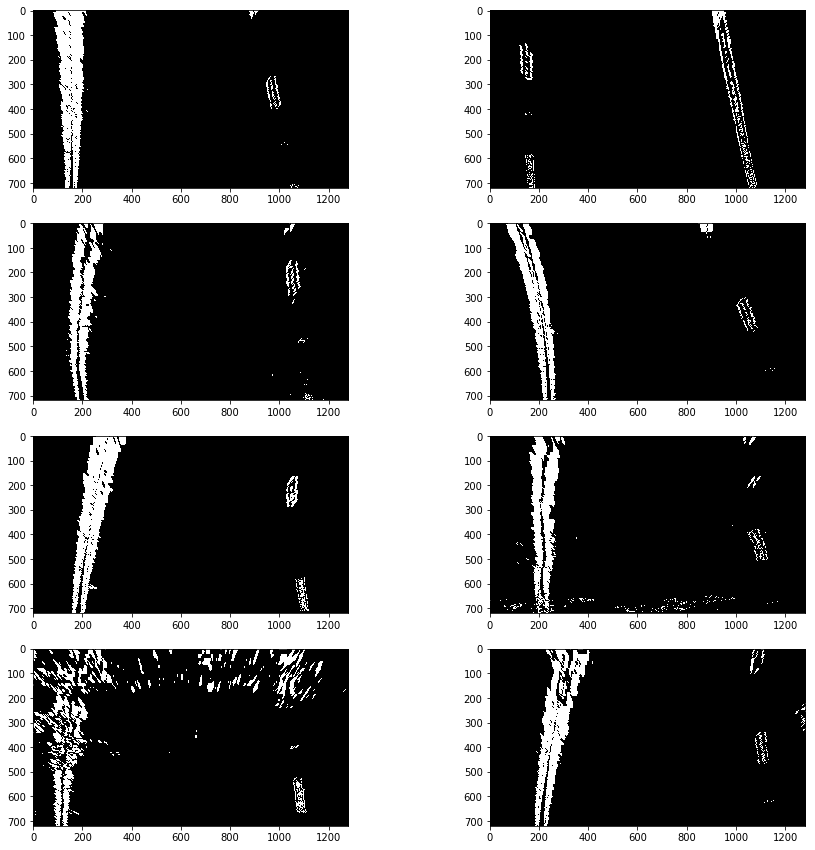

In [8]:
show_images(output_images, cmap='gray')

In [9]:
def sliding_windows_fit(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 130
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy

(720, 1280)
(720, 1280, 3)


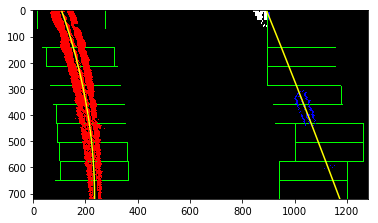

In [10]:
def visualize_birds_eye(img):
    binary_warped = img_pipeline(img)
    print(binary_warped.shape)
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = sliding_windows_fit(binary_warped)
    print(out_img.shape)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return ploty

ploty = visualize_birds_eye(cv2.imread('./test_images/test2.jpg'))

In [11]:
def drawLine(img, bin_img, left_fit, right_fit):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [12]:
def get_curvature(left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    center_idx = 1280//2
    identified_lanes_center_idx = (min(leftx) + max(rightx))//2
    
    center_dist = np.abs(center_idx - identified_lanes_center_idx)*xm_per_pix
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center_dist)

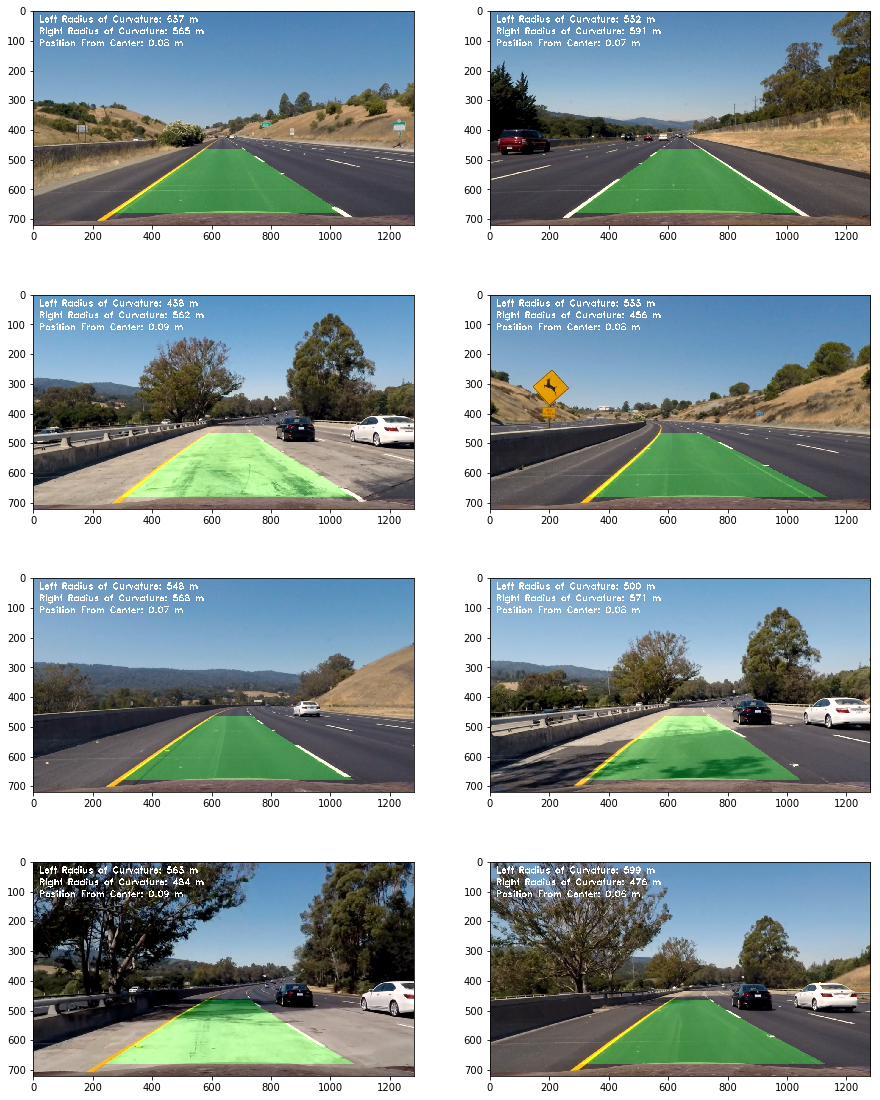

In [13]:
font = cv2.FONT_HERSHEY_DUPLEX
font_color = (255,255,255)

fig, ax = plt.subplots(4, 2, figsize=(15, 20))
ax = ax.ravel()
for i, img in enumerate(images):
    binary_warped = img_pipeline(img)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = sliding_windows_fit(binary_warped)
    final = drawLine(img, binary_warped, left_fit, right_fit)
    curvature = get_curvature(left_fit, right_fit)
    cv2.putText(final, 'Left Radius of Curvature: {:.0f} m'.format(curvature[0]), (20,40), font, 1, font_color, 2)
    cv2.putText(final, 'Right Radius of Curvature: {:.0f} m'.format(curvature[1]), (20,80), font, 1, font_color, 2)
    cv2.putText(final, 'Position From Center: {:.2f} m'.format(curvature[2]), (20,120), font, 1, font_color, 2)
    ax[i].imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

In [14]:
def total_pipeline(img):
    binary_warped = img_pipeline(img)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = sliding_windows_fit(binary_warped)
    left.recent_fit.append(left_fit)
    right.recent_fit.append(right_fit)
    left.get_avg()
    right.get_avg()
    final = drawLine(img, binary_warped, left.avg_fit, right.avg_fit)
    curvature = get_curvature(left.avg_fit, right.avg_fit)
    cv2.putText(final, 'Left Radius of Curvature: {:.0f} m'.format(curvature[0]), (20,40), font, 1, font_color, 2)
    cv2.putText(final, 'Right Radius of Curvature: {:.0f} m'.format(curvature[1]), (20,80), font, 1, font_color, 2)
    cv2.putText(final, 'Position From Center: {:.2f} m'.format(curvature[2]), (20,120), font, 1, font_color, 2)
    return final

In [19]:
class Line():
    def __init__(self):  
        # queue for last 10 fits
        self.recent_fit = deque([], maxlen=10)
        self.avg_fit = None
    
    def get_avg(self):
        fits = self.recent_fit
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avg_fit = avg

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left = Line()
right = Line()

video_output = 'project_video_output_10q.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(total_pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output_10q.mp4
[MoviePy] Writing video project_video_output_10q.mp4


100%|█████████▉| 1260/1261 [04:12<00:00,  4.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_10q.mp4 

Wall time: 4min 13s
